**Disclaimer**: this notebook's compatibility with StatsBomb event data 4.0.0 was last checked on December 30th, 2023.

In [1]:
import sys, pandera, multimethod
print(sys.version)
print("pandera:", pandera.__version__, "| multimethod:", multimethod.__version__)

3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
pandera: 0.17.2 | multimethod: 1.10


In [1]:
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl
import pandas as pd


In [12]:
%autoreload 0

# clean out mismatched versions
!pip uninstall -y pandera multimethod

# install versions that work together
!pip install "pandera==0.17.2" "multimethod==1.10.0" tqdm

Found existing installation: pandera 0.17.2
Uninstalling pandera-0.17.2:
  Successfully uninstalled pandera-0.17.2
Found existing installation: multimethod 1.10
Uninstalling multimethod-1.10:
  Successfully uninstalled multimethod-1.10
  Using cached pandera-0.17.2-py3-none-any.whl.metadata (15 kB)
  Using cached multimethod-1.10-py3-none-any.whl.metadata (8.2 kB)
Using cached pandera-0.17.2-py3-none-any.whl (203 kB)
Using cached multimethod-1.10-py3-none-any.whl (9.9 kB)

   -------------------- ------------------- 1/2 [pandera]
   -------------------- ------------------- 1/2 [pandera]
   -------------------- ------------------- 1/2 [pandera]
   -------------------- ------------------- 1/2 [pandera]
   -------------------- ------------------- 1/2 [pandera]
   -------------------- ------------------- 1/2 [pandera]
   -------------------- ------------------- 1/2 [pandera]
   ---------------------------------------- 2/2 [pandera]



In [4]:
!pip install tqdm

In [2]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
warnings.filterwarnings(action="ignore", message="credentials were not supplied. open data access only")
import tqdm

In [7]:
!pip install "pandera==0.17.2" "multimethod==1.10.0" tqdm

  Attempting uninstall: multimethod
    Found existing installation: multimethod 2.0
    Uninstalling multimethod-2.0:
      Successfully uninstalled multimethod-2.0


In [7]:
pip install statsbombpy


   ---------------------------------------- 0/6 [url-normalize]
   ------------- -------------------------- 2/6 [cattrs]
   ------------- -------------------------- 2/6 [cattrs]
   ------------- -------------------------- 2/6 [cattrs]
   -------------------- ------------------- 3/6 [requests-cache]
   -------------------- ------------------- 3/6 [requests-cache]
   -------------------- ------------------- 3/6 [requests-cache]
   --------------------------------- ------ 5/6 [statsbombpy]
   ---------------------------------------- 6/6 [statsbombpy]

Note: you may need to restart the kernel to use updated packages.


In [3]:
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})
comps = SBL.competitions()
comps[["competition_name","season_name"]].head()

,competition_name,season_name
0,1. Bundesliga,2023/2024
1,1. Bundesliga,2015/2016
2,African Cup of Nations,2023
3,Champions League,2018/2019
4,Champions League,2017/2018


In [4]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

## Set up the StatsBombLoader

In [5]:
# Use this if you want to use the free public statsbomb data
# or provide credentials to access the API
SBL = StatsBombLoader(getter="remote", creds={"user": None, "passwd": None})

# # Uncomment the code below if you have a local folder on your computer with statsbomb data
# datafolder = "../data/statsbomb-epl-1718" # Example of local folder with statsbomb data
# SBL = StatsBombLoader(root=datafolder, getter="local")

In [6]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'1. Bundesliga',
 'African Cup of Nations',
 'Champions League',
 'Copa America',
 'Copa del Rey',
 "FA Women's Super League",
 'FIFA U20 World Cup',
 'FIFA World Cup',
 'Indian Super league',
 'La Liga',
 'Liga Profesional',
 'Ligue 1',
 'Major League Soccer',
 'NWSL',
 'North American League',
 'Premier League',
 'Serie A',
 'UEFA Euro',
 'UEFA Europa League',
 "UEFA Women's Euro",
 "Women's World Cup"}

In [7]:
# Fifa world cup
selected_competitions = competitions[
    (competitions.competition_name == "FIFA World Cup")
    & (competitions.season_name == "2018")
]

# # Messi data
# selected_competitions = competitions[competitions.competition_name == "La Liga"]

# # FA Women's Super League
# selected_competitions = competitions[competitions.competition_name == "FA Women's Super League"]

selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
30,3,43,FIFA World Cup,International,male,2018


In [8]:
# Get games from all selected competitions
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,769,768,2018-07-03 20:00:00,1,1
1,768,782,2018-06-28 20:00:00,0,1
2,790,773,2018-07-03 16:00:00,1,0
3,797,780,2018-06-25 20:00:00,1,1
4,780,788,2018-06-20 14:00:00,1,0
...,...,...,...,...,...
59,796,774,2018-06-19 20:00:00,3,1
60,796,785,2018-07-07 20:00:00,2,2
61,776,771,2018-06-26 16:00:00,0,0
62,778,787,2018-06-24 17:00:00,2,2


## Load and convert match data

In [9]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(
        events, 
        home_team_id=game.home_team_id,
        xy_fidelity_version=1,
        shot_fidelity_version=1
    )

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data:   0%|                                                                                                                                   | 0/64 [00:00<?, ?it/s]C:\Users\Arya1\OneDrive\Documents\GitHub\Group-60\socceraction-master\socceraction\data\statsbomb\loader.py:337: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  eventsdf["under_pressure"] = eventsdf["under_pressure"].fillna(False).astype(bool)
C:\Users\Arya1\OneDrive\Documents\GitHub\Group-60\socceraction-master\socceraction\data\statsbomb\loader.py:338: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_down

## Store converted spadl data in a h5-file

In [11]:
pip install tables

   ---------------------------------------- 0.0/6.4 MB ? eta -:--:--
   ------------------ --------------------- 2.9/6.4 MB 24.0 MB/s eta 0:00:01
   ---------------------------------------- 6.4/6.4 MB 26.3 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 18.3 MB/s  0:00:00

   ------ --------------------------------- 1/6 [numexpr]
   ------------- -------------------------- 2/6 [ndindex]
   ------------- -------------------------- 2/6 [ndindex]
   ------------- -------------------------- 2/6 [ndindex]
   -------------------------- ------------- 4/6 [blosc2]
   -------------------------- ------------- 4/6 [blosc2]
   --------------------------------- ------ 5/6 [tables]
   --------------------------------- ------ 5/6 [tables]
   --------------------------------- ------ 5/6 [tables]
   --------------------------------- ------ 5/6 [tables]
   --------------------------------- ------ 5/6 [tables]
   --

In [12]:
datafolder = "../data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

## Plot the spadl data
Extra library required: ```pip install matplotsoccer```

In [13]:
pip install matplotsoccer

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Created wheel for matplotsoccer: filename=matplotsoccer-0.0.8-py3-none-any.whl size=6032 sha256=654fb20a275ac08d9a74fb8181ba290619bc7059a3d92499275feade8ad347af
  Stored in directory: c:\users\arya1\appdata\local\pip\cache\wheels\5f\96\51\a91e3de14cbbb035d664ca08bf412678bda3e5c7864f9ba66d
Successfully built matplotsoccer
Note: you may need to restart the kernel to use updated packages.


In [14]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.competition_name == "FIFA World Cup") 
                  & (games.away_team_name == "England")
                  & (games.home_team_name == "Belgium")]
    game_id = game.game_id.values[0]
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x.iloc[0] if x.iloc[0] else x.iloc[1], axis=1)
del actions['nickname']
actions[:5]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,8657,84438495-6341-4eba-bf90-82db1f6703fb,1,0.533,782,3289.0,52.9375,33.575,44.1875,33.575,0,1,5,0,pass,success,foot_right,Romelu Lukaku,Belgium
1,8657,6f02abb4-0b81-4531-be11-6bf6ea7e695b,1,1.252,782,5642.0,44.1875,33.575,44.1875,34.425,21,1,0,1,dribble,success,foot,Axel Witsel,Belgium
2,8657,34b355a6-8b5f-4954-8dfd-fcc77df5c40c,1,2.133,782,5642.0,44.1875,34.425,31.9375,53.125,0,1,5,2,pass,success,foot_right,Axel Witsel,Belgium
3,8657,29b70f75-5970-491c-acc7-5dbfb353200c,1,3.732,782,3077.0,31.9375,53.125,28.4375,53.125,21,1,0,3,dribble,success,foot,Jan Vertonghen,Belgium
4,8657,8fd1ffd0-b984-4823-ab2c-f249c04adc12,1,4.933,782,3077.0,28.4375,53.125,24.0625,38.675,0,1,4,4,pass,success,foot_left,Jan Vertonghen,Belgium


In [16]:
pip install matplotlib

   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------- ----------------------- 3.4/8.1 MB 25.2 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 27.8 MB/s  0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------------------------------------- 2.3/2.3 MB 25.7 MB/s  0:00:00
   ---------------------------------------- 0.0/7.0 MB ? eta -:--:--
   ---------------------------------------  6.8/7.0 MB 42.0 MB/s eta 0:00:01
   ---------------------------------------- 7.0/7.0 MB 33.1 MB/s  0:00:00

   ---------------------------------------- 0/7 [pyparsing]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- ---------------------------------- 1/7 [pillow]
   ----- -----

2018-07-14 16:00:00 Belgium 2-0 England 82'


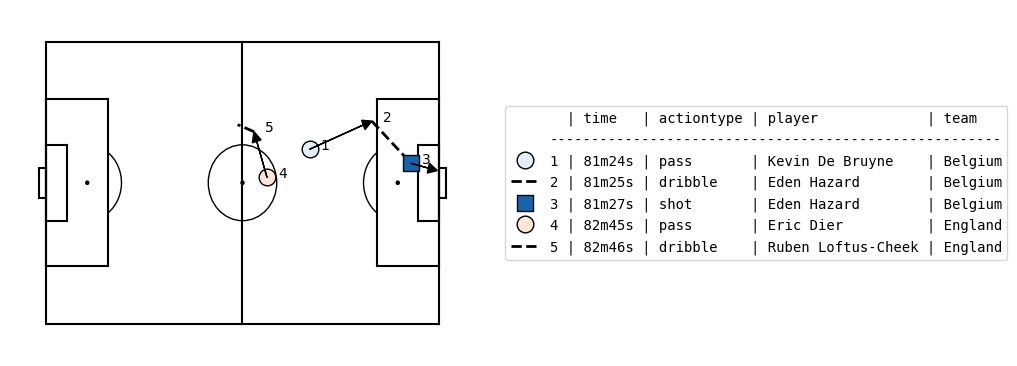

In [17]:
import matplotsoccer

# Select the 5 actions preceding the 2-0
shot = 2201
a = actions[shot-4:shot+1].copy()

# Print the game date and timestamp of the goal
g = game.iloc[0]
minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)